In [44]:
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array, array_to_img, img_to_array, load_img

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [26]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [12]:
# x_train.shape
for i in x_train[:10]:
    t = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    print(i.shape, t.shape)

(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)
(32, 32, 3) (32, 32)


In [29]:
def rgb_to_grayscale(images):
    grayscale_images = []
    for image in images:
        # Convert using OpenCV's BGR to grayscale conversion (assumes BGR format)
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        grayscale_images.append(grayscale_image)
    return np.array(grayscale_images)

# Apply grayscale conversion
x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], 32, 32, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], 32, 32, 1)

# Normalize pixel values (optional but recommended)
x_train_gray = x_train_gray.astype('float32') / 255
x_test_gray = x_test_gray.astype('float32') / 255

##### Task 1: Perform standard PCA and identify the eigenvectors associated with top eigenvalues with 95% total energy (i,e.,  >=95 percent). Using these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.

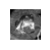

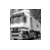

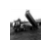

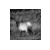

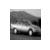

In [34]:
num_images_to_print = 5
for i in range(num_images_to_print):
    plt.figure(figsize=(0.4,0.4))
    plt.imshow(x_train_gray[i], cmap='gray')
    # plt.title(f'Grayscale Image {i+1}')
    plt.axis('off')
plt.show()

In [52]:
num_images = x_train_gray.shape[0]
image_size = np.prod(x_train_gray.shape[1:])
x_flat = x_train_gray.reshape(num_images, image_size)

# begin normalisation for pca
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_flat)

pca = PCA()
pca.fit(X_scaled)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(n_components)

pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

num_images, image_size, X_scaled.shape, X_pca.shape

159


(50000, 1024, (50000, 1024), (50000, 159))

In [53]:
random_pca = PCA(svd_solver='randomized')
random_pca.fit(X_scaled)
random_cumulative_variance_ratio = np.cumsum(random_pca.explained_variance_ratio_)
nr_components = np.argmax(random_cumulative_variance_ratio >= 0.95) + 1
print(nr_components)

random_pca = PCA(n_components=nr_components, svd_solver='randomized')
X_pca_random = random_pca.fit_transform(X_scaled)
X_pca_random.shape

159


(50000, 159)